In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/shelter-animal-outcomes/sample_submission.csv.gz
/kaggle/input/shelter-animal-outcomes/train.csv.gz
/kaggle/input/shelter-animal-outcomes/test.csv.gz


# 1. 데이터 가져오기

In [2]:
train = pd.read_csv('/kaggle/input/shelter-animal-outcomes/train.csv.gz')
test = pd.read_csv('/kaggle/input/shelter-animal-outcomes/test.csv.gz')

In [3]:
all_data = pd.concat([train, test]).reset_index(drop=True)

In [4]:
all_data

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,ID
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,NaN
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,NaN
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,NaN
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,NaN
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,NaN
...,...,...,...,...,...,...,...,...,...,...,...
38180,NaN,NaN,2014-07-08 14:50:00,NaN,NaN,Cat,Neutered Male,2 months,Domestic Shorthair Mix,Black,11452.0
38181,NaN,NaN,2014-10-21 12:57:00,NaN,NaN,Cat,Intact Female,2 weeks,Domestic Shorthair Mix,Blue,11453.0
38182,NaN,NaN,2014-09-29 09:00:00,NaN,NaN,Cat,Intact Female,1 year,Domestic Shorthair Mix,Calico,11454.0
38183,NaN,Rambo,2015-09-05 17:16:00,NaN,NaN,Dog,Neutered Male,6 years,German Shepherd Mix,Black/Tan,11455.0


# 2. 메타데이터 전처리

## 날짜 데이터 처리하기

In [5]:
#날짜 처리는 all_data를 concat한 뒤에 바로 추가하는 게 좋음 
all_data['DateTime'] = all_data['DateTime'].astype('datetime64')
all_data['Year'] = all_data['DateTime'].dt.year
all_data['Month'] = all_data['DateTime'].dt.month
all_data['Day'] = all_data['DateTime'].dt.day 
all_data['Hour'] = all_data['DateTime'].dt.hour
all_data['Minute'] = all_data['DateTime'].dt.minute
all_data['Week'] = all_data['DateTime'].dt.week #공휴일도 영향을 줌 
all_data['DayOfWeek'] = all_data['DateTime'].dt.weekday

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


## AgeuponOutcome 단위 통일하기

In [6]:
def age(x): #날짜 단위 통일하는 함수 만들기
    
    if pd.isnull(x): #결측치 처리(결측치의 dtype이 float)
        return -1
    num = int(x.split()[0]) 
    
    if 'year' in x:
        return 365*num
    elif 'month' in x:
        return 30*num
    elif 'week' in x:
        return 7*num
    else:
        return num

In [7]:
all_data['AgeuponOutcome'] = all_data['AgeuponOutcome'].apply(age)

In [8]:
all_data.head(5)

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,ID,Year,Month,Day,Hour,Minute,Week,DayOfWeek
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,365,Shetland Sheepdog Mix,Brown/White,NaN,2014,2,12,18,22,7,2
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,365,Domestic Shorthair Mix,Cream Tabby,NaN,2013,10,13,12,44,41,6
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,730,Pit Bull Mix,Blue/White,NaN,2015,1,31,12,28,5,5
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,21,Domestic Shorthair Mix,Blue Cream,NaN,2014,7,11,19,9,28,4
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,730,Lhasa Apso/Miniature Poodle,Tan,NaN,2013,11,15,12,52,46,4


## Animal ID Numerical 성격을 살려주기

In [9]:
all_data['Name'] = all_data['Name'].notnull()

In [10]:
all_data['AnimalID'] = all_data['AnimalID'].apply(str)
all_data['AnimalID'] = all_data['AnimalID'].apply(lambda x: x[1:])

In [11]:
all_data

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,ID,Year,Month,Day,Hour,Minute,Week,DayOfWeek
0,671945,True,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,365,Shetland Sheepdog Mix,Brown/White,NaN,2014,2,12,18,22,7,2
1,656520,True,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,365,Domestic Shorthair Mix,Cream Tabby,NaN,2013,10,13,12,44,41,6
2,686464,True,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,730,Pit Bull Mix,Blue/White,NaN,2015,1,31,12,28,5,5
3,683430,False,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,21,Domestic Shorthair Mix,Blue Cream,NaN,2014,7,11,19,9,28,4
4,667013,False,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,730,Lhasa Apso/Miniature Poodle,Tan,NaN,2013,11,15,12,52,46,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38180,an,False,2014-07-08 14:50:00,NaN,NaN,Cat,Neutered Male,60,Domestic Shorthair Mix,Black,11452.0,2014,7,8,14,50,28,1
38181,an,False,2014-10-21 12:57:00,NaN,NaN,Cat,Intact Female,14,Domestic Shorthair Mix,Blue,11453.0,2014,10,21,12,57,43,1
38182,an,False,2014-09-29 09:00:00,NaN,NaN,Cat,Intact Female,365,Domestic Shorthair Mix,Calico,11454.0,2014,9,29,9,0,40,0
38183,an,True,2015-09-05 17:16:00,NaN,NaN,Dog,Neutered Male,2190,German Shepherd Mix,Black/Tan,11455.0,2015,9,5,17,16,36,5


## 텍스트 데이터 vectorize 사용하기

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
breed_text = vectorizer.fit_transform(all_data['Breed']).toarray()

vectorizer = TfidfVectorizer()
color_text = vectorizer.fit_transform(all_data['Color']).toarray()

In [13]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=10) #n_components를 변경해가면서 적정한 차원을 설정 (for loop)
breed_svd = svd.fit_transform(breed_text)
breed_svd

array([[ 0.04707169,  0.02519441,  0.01397944, ...,  0.00413413,
         0.01687155, -0.00240925],
       [ 0.99449628, -0.04320528, -0.03968845, ...,  0.00402912,
         0.0040981 ,  0.00387179],
       [ 0.12788388,  0.95402749, -0.2664519 , ..., -0.01042206,
        -0.0239517 ,  0.01154868],
       ...,
       [ 0.99449628, -0.04320528, -0.03968845, ...,  0.00402912,
         0.0040981 ,  0.00387179],
       [ 0.09154683,  0.08398613,  0.1198004 , ..., -0.23416689,
         0.01568873, -0.00291674],
       [ 0.0176188 ,  0.24462142,  0.88029282, ..., -0.02614256,
        -0.04043364,  0.00607334]])

In [14]:
svd = TruncatedSVD(n_components=10) 
color_svd = svd.fit_transform(color_text)
color_svd

array([[ 6.07995290e-01,  6.24923323e-01,  9.68839977e-02, ...,
        -2.51950339e-02, -3.57435185e-02, -7.68960604e-03],
       [ 8.40863293e-02,  2.46263029e-01, -8.33209746e-02, ...,
         2.69588074e-02, -2.20658660e-01,  5.32465229e-02],
       [ 3.25392177e-01,  1.44662753e-01,  5.00208206e-01, ...,
        -1.67185147e-02,  4.90766564e-02, -6.27879897e-03],
       ...,
       [ 1.04182974e-03,  4.64804165e-04,  1.86416085e-03, ...,
        -1.55480945e-03, -3.57043129e-03,  2.68156940e-02],
       [ 5.10892105e-01, -3.51989608e-01,  1.37841955e-01, ...,
         1.29539221e-02,  2.17972506e-02,  1.28629322e-03],
       [ 9.31152176e-03,  1.81503161e-02,  5.32989050e-03, ...,
         1.45088380e-02, -1.45746306e-01,  5.53738058e-02]])

In [15]:
all_data = pd.concat([all_data,pd.DataFrame(breed_svd)],axis=1)
all_data = pd.concat([all_data,pd.DataFrame(color_svd)],axis=1)

## all_data2 데이터 셋 만들기

In [16]:
all_data2 = all_data.drop(columns=['DateTime','OutcomeSubtype','OutcomeType','Breed','Color''ID']) 
#AnimalID도 도움이 될 수도 있음 - 데이터가 숫자적인 관계를 지닐수도 있어서, or 알파벳이 의미를 지닐 수도 있음 

KeyError: "['DateTime' 'OutcomeSubtype' 'OutcomeType' 'Breed' 'ColorID'] not found in axis"

In [17]:
all_data2

NameError: name 'all_data2' is not defined

In [18]:
all_data2['Name'].astype(str) #series 
list(all_data2['Name'])



NameError: name 'all_data2' is not defined

## 데이터 분포 살펴보기

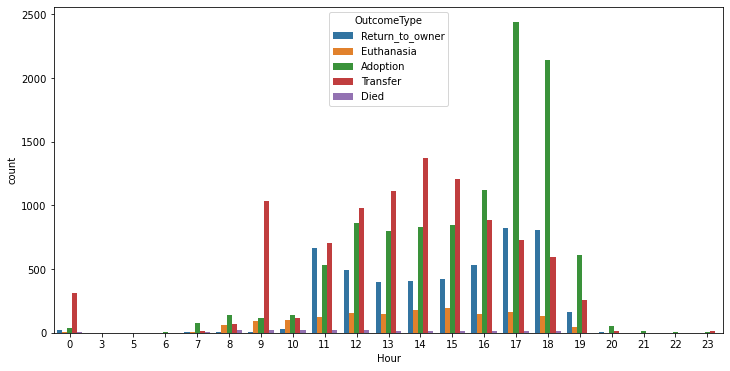

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12,6))
sns.countplot(all_data['Hour'], hue=all_data['OutcomeType']) #둘 다 문자일 때 countplot
#입양이 많은 시간 
#Transfer를 보내는 시간이 정해져있을 수 있음(자정, 오전9시)

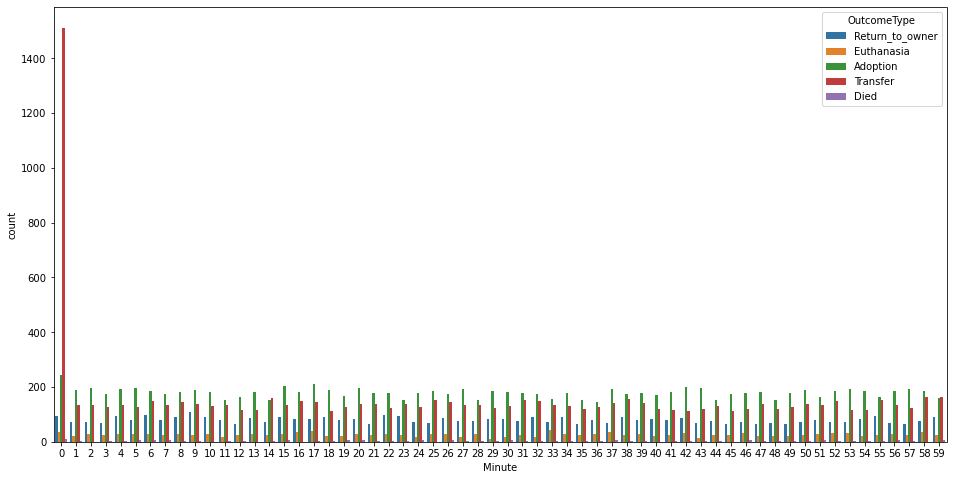

In [20]:
plt.figure(figsize=(16,8))
sns.countplot(all_data['Minute'],hue=all_data['OutcomeType'])
#모델이 '분'을 카테고리컬 형식으로 학습을 함 <- 특정 분에 따라서 변하게 
#categorical 느낌이 많은데 모델이 numerical로 학습하면 결과가 안좋아짐 >>> categorical로 인식하도록 명령해줘야 함

## LabelEncoder 처리하여, Categorical변수 학습 가능하도록 만들기

In [21]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
c = all_data2.columns[all_data2.dtypes == object]
for i in c:
    all_data2[i] = le.fit_transform(list(all_data2[i])) #float: 결측치를 float으로 알아들음 -> *******결측치가 list를 만나면 string으로 받아들여짐 

NameError: name 'all_data2' is not defined

In [22]:
all_data2 = all_data2.fillna(-1)

NameError: name 'all_data2' is not defined

In [23]:
train2 = all_data2[:len(train)]
test2 = all_data2[len(train):]

NameError: name 'all_data2' is not defined

In [24]:
train2

NameError: name 'train2' is not defined

# 3.학습시키기 (Catboost)

In [25]:
#GPU는 랜덤성이 있음 (시드값 줘도)
from catboost import CatBoostClassifier
cbc = CatBoostClassifier()
cbc.fit(train2, train['OutcomeType'], cat_features=[1,5,6])
result = cbc.predict_proba(test2)

NameError: name 'train2' is not defined

In [26]:
sub = pd.read_csv('/kaggle/input/shelter-animal-outcomes/sample_submission.csv.gz')

In [27]:
sub.iloc[:,1:] = result 

NameError: name 'result' is not defined

In [28]:
sub.to_csv('submission.csv', index=False)